<a href="https://colab.research.google.com/github/mariang168/SU_MSADS/blob/main/Zip98340.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## SAMPLE TIME SERIES USING RETAIL DATA
## BASED ON MILLER (2015) and BROWNLEE (2016)

import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from math import sqrt
from pandas import DataFrame
from scipy.stats import boxcox
import seaborn as sns
import numpy as np

## Setting Seaborn Styles
sns.set(style="whitegrid")
sns.set_palette((sns.color_palette('tab10', 8)))
dims = (11.7, 8.27)
%matplotlib inline

## Setting random seed
np.random.seed(1000)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Zip97212 = pd.read_csv("Zip97212.csv").fillna(0)
#Zip94804 = pd.read_csv("Zip94804.csv").fillna(0)
Zip98340 = pd.read_csv("https://raw.githubusercontent.com/mariang168/SU_MSADS/main/IST718/Zip98340.csv").fillna(0)

In [ ]:
#Zip98340
W_t = Zip98340.transpose()
W_t = pd.DataFrame(W_t)
W = W_t.drop(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'])
#O = O.sort_index()
W.index.name = "Date"
W.index = pd.to_datetime(W.index)
W['Price']= W.mean(axis=1)
W

,0,Price
Date,,
1996-01-31,191011.3635,191011.3635
1996-02-29,192316.2851,192316.2851
1996-03-31,190654.1577,190654.1577
1996-04-30,191905.3462,191905.3462
1996-05-31,194219.0758,194219.0758
...,...,...
2022-02-28,838026.7311,838026.7311
2022-03-31,836825.286,836825.2860
2022-04-30,850128.4288,850128.4288


In [ ]:
# EXPLORE - IS OUR TIME SERIES STATIONARY OR NOT?

result = adfuller(W['Price'], autolag='AIC')

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.555434
p-value: 0.986464
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


ADF Statistic: -0.971599
p-value: 0.763481
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572


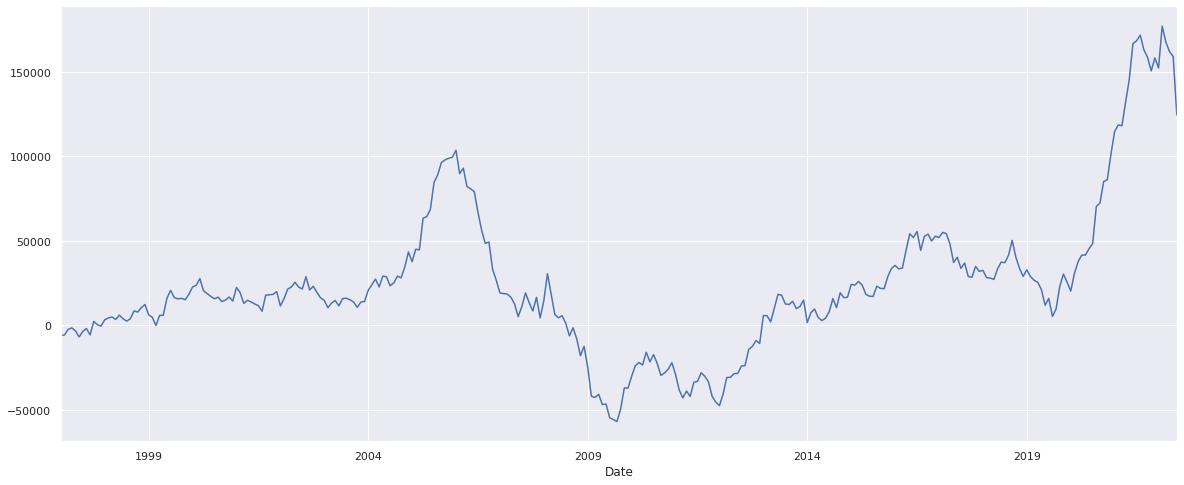

In [ ]:
# SCRUB - OUR TIME SERIES IS NOT STATIONARY - WE NEED TO TAKE THE DIFFERENCE
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

#X = O['Price']
X = W['Price']
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = W.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

# plot
stationary.plot()

In [ ]:
# SCRUB - SOME CODE TO INVERT DIFFERENCE VALUE

def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

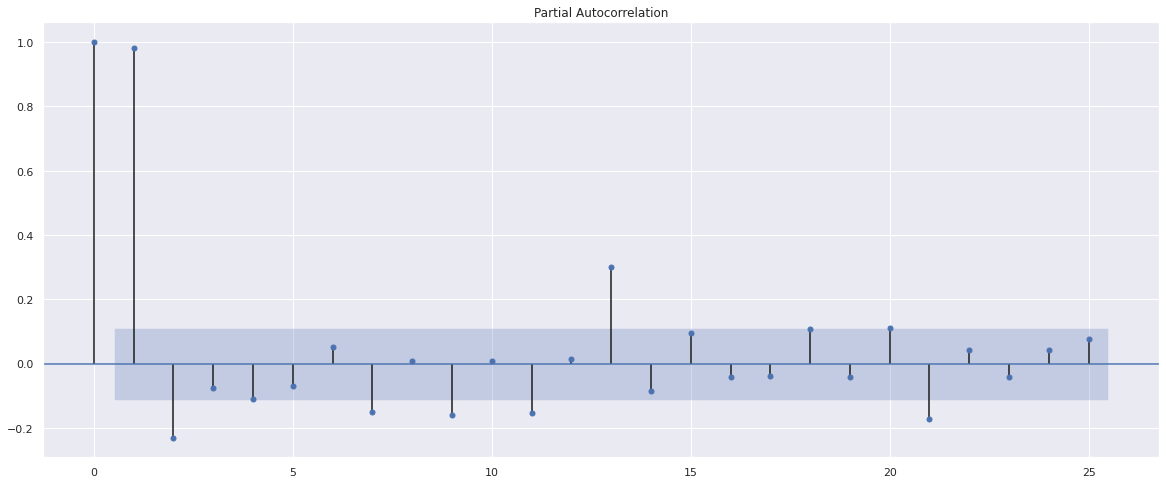

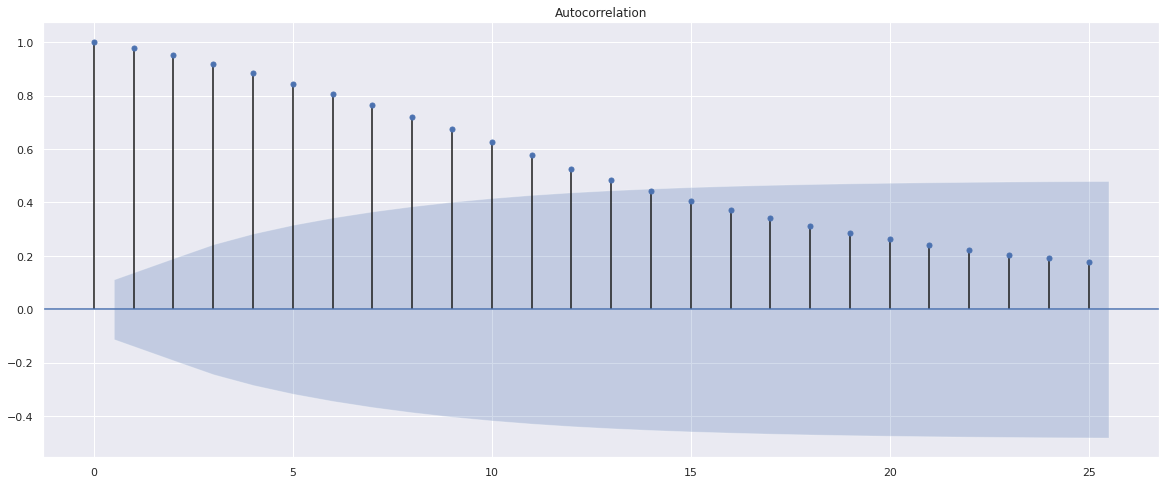

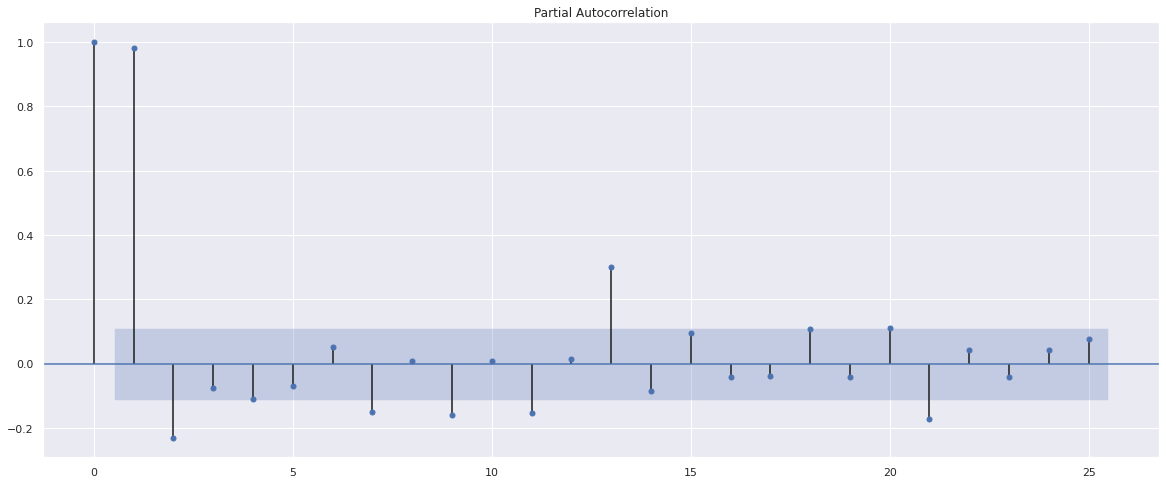

In [ ]:
# USING STATIONARY TIME SERIES LOOK AT ACF

series = stationary

plot_acf(series)
plot_pacf(series)

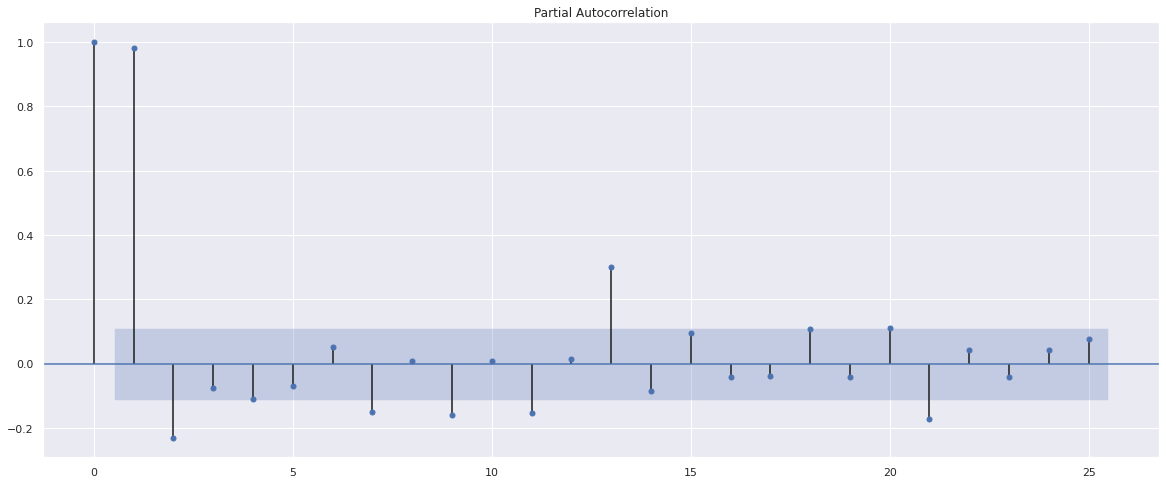

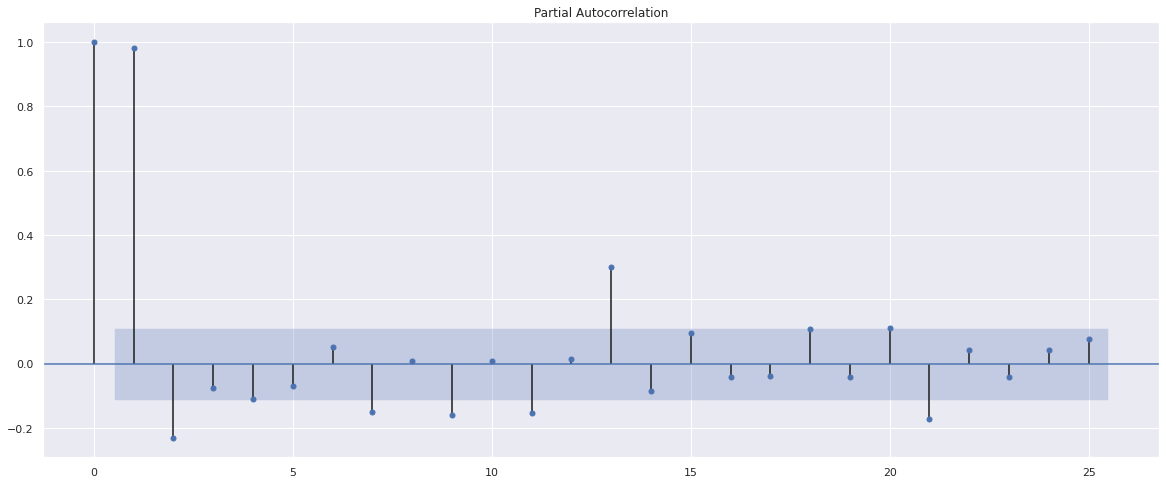

In [ ]:
# USING STATIONARY TIME SERIES LOOK FOR PACF

plot_pacf(series)

In [ ]:
# BUILD THE MODEL - USING ORIGINAL SERIES1 DATA

# prepare data
#X = O['Price']
X = W['Price']
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(2,1,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=420441.777, Expected=423472
>Predicted=423586.100, Expected=417602
>Predicted=416022.436, Expected=416400
>Predicted=418743.010, Expected=410980
>Predicted=409519.655, Expected=408707
>Predicted=410048.115, Expected=409479
>Predicted=400438.518, Expected=407963
>Predicted=398555.058, Expected=410889
>Predicted=408128.162, Expected=406836
>Predicted=401056.391, Expected=407303
>Predicted=401983.951, Expected=407861
>Predicted=405452.159, Expected=406456
>Predicted=402080.719, Expected=400092
>Predicted=394297.529, Expected=401717
>Predicted=400788.982, Expected=394854
>Predicted=389814.086, Expected=393669
>Predicted=391059.392, Expected=386151
>Predicted=387134.887, Expected=379916
>Predicted=377640.263, Expected=379835
>Predicted=382211.054, Expected=384989
>Predicted=381146.008, Expected=384820
>Predicted=385637.560, Expected=378335
>Predicted=378950.387, Expected=369653
>Predicted=367279.015, Expected=363587
>Predicted=356243.349, Expected=361255
>Predicted=362753.105, Ex

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                  0
count    159.000000
mean     987.712645
std     7217.177519
min   -34397.657892
25%    -3337.184963
50%      332.895798
75%     4529.820190
max    25275.729730
RMSE: 7261.930


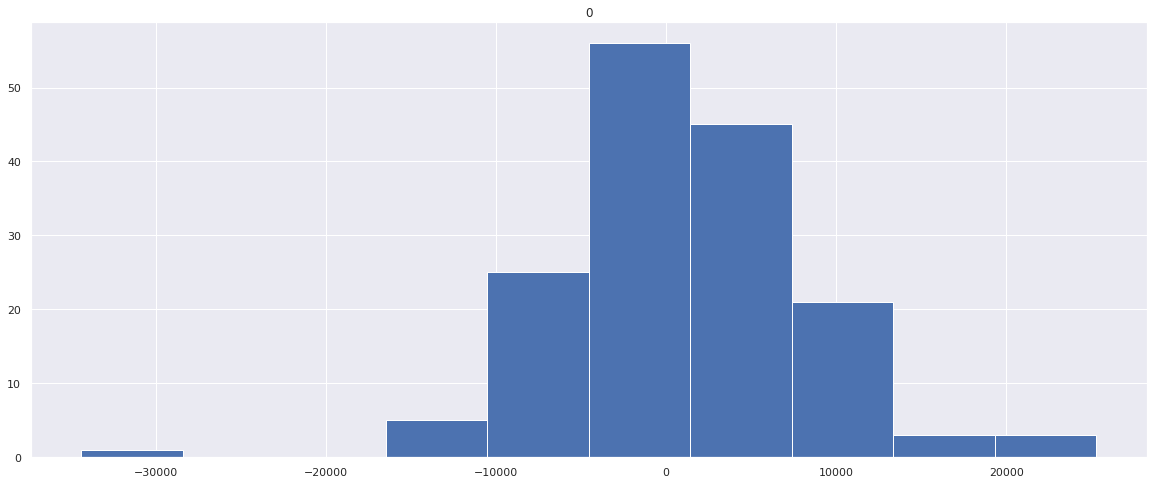

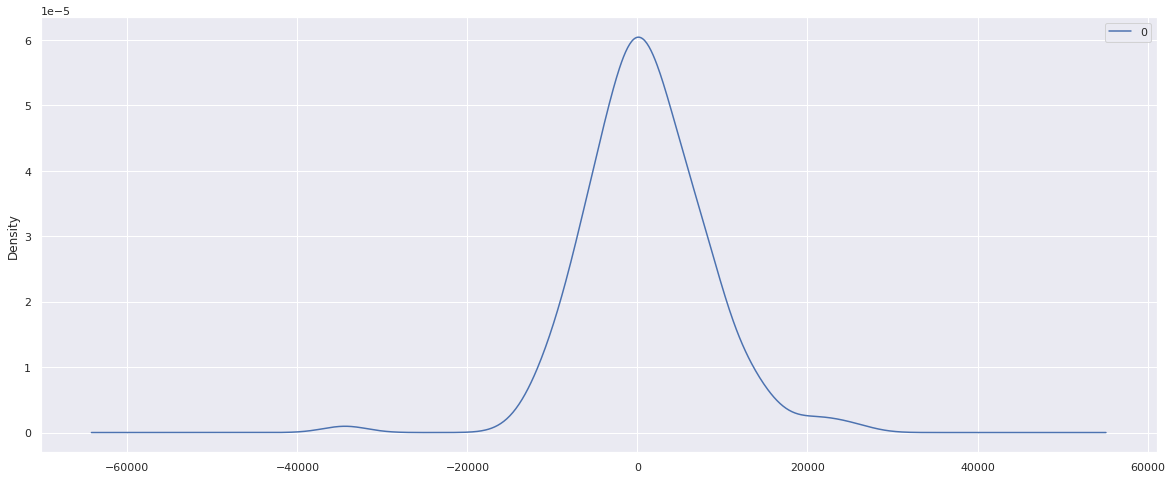

In [ ]:
#Zip97212 ARIMA()
#@title
# SIMILAR BLOCK OF CODE - THIS ONE SAVES RESIDUALS FOR PLOTTING

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load data
series = W['Price']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,1,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
# plot
residuals.hist(ax=plt.gca())
plt.show()

residuals.plot(kind='kde', ax=plt.gca())
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                  0
count     80.000000
mean    1320.980886
std     8663.256557
min   -34276.944805
25%    -4064.948267
50%      750.924049
75%     5123.455828
max    25396.442817
RMSE: 8709.699


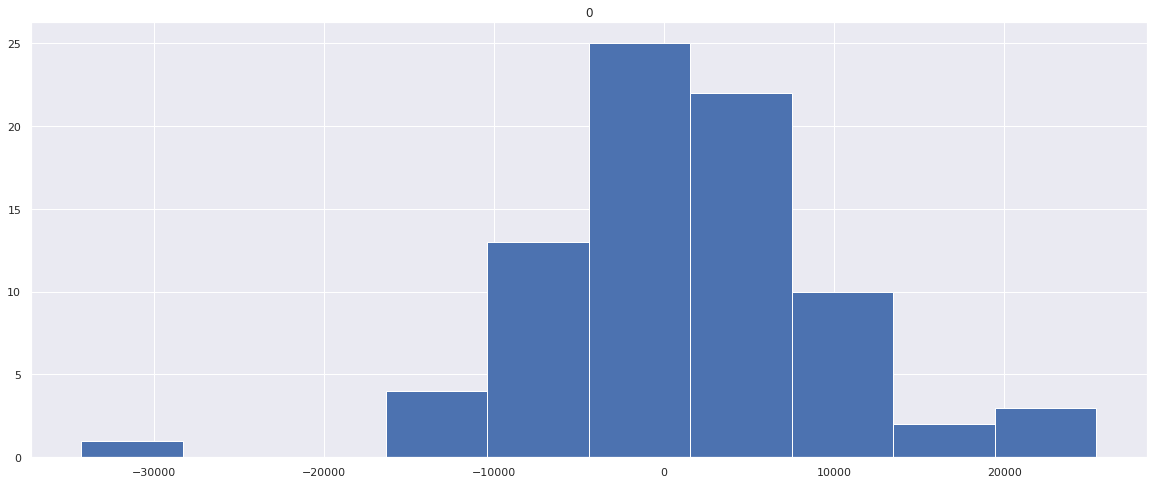

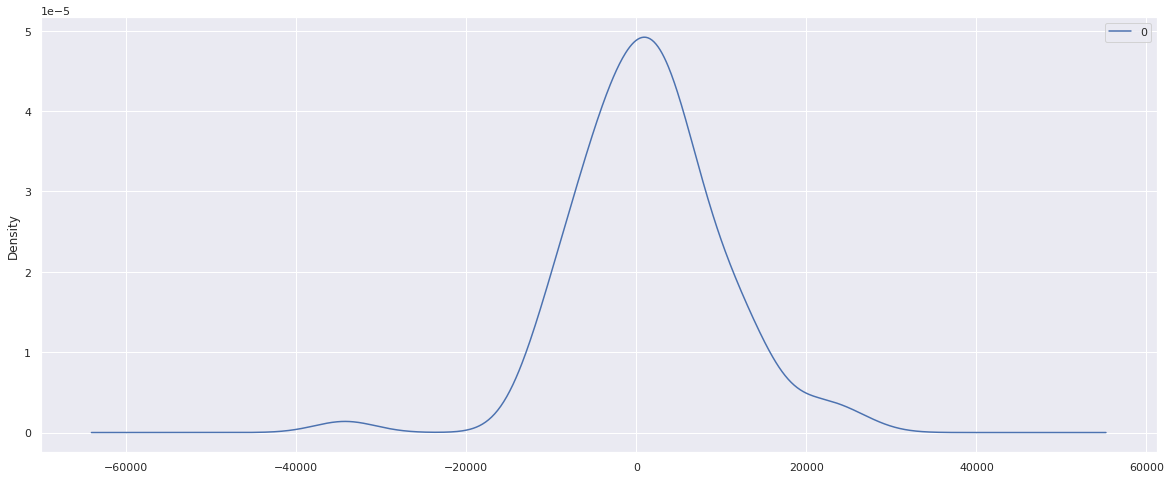

In [ ]:
# MODEL - INTERPRET 
# RECREATE ANALYSIS WITH MEAN RESIDUAL ADDED TO EACH PREDICTION
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load data
series = W['Price']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.75)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = -120.713087
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,1,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
# plot
residuals.hist(ax=plt.gca())
plt.show()

residuals.plot(kind='kde', ax=plt.gca())
plt.show()

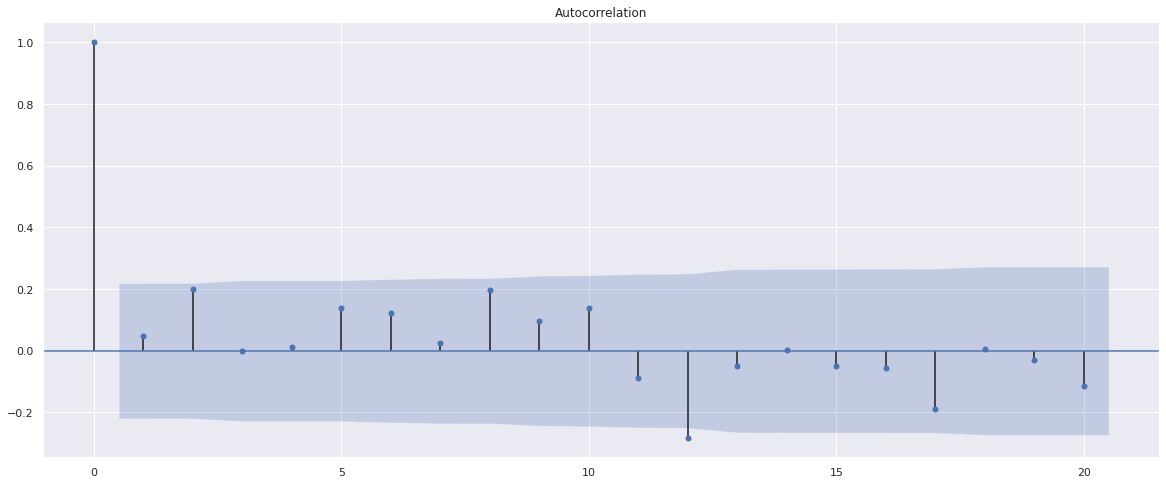

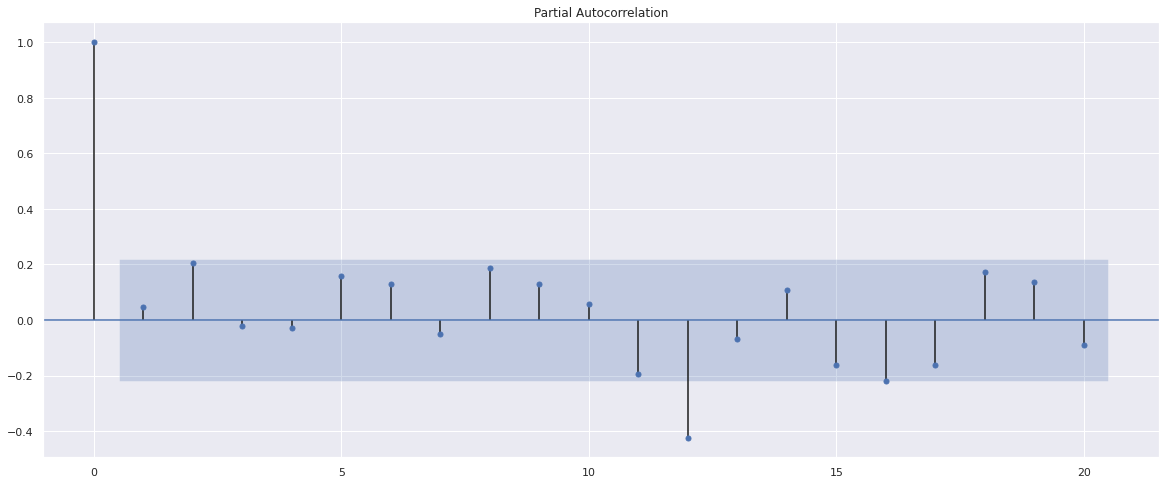

In [ ]:
# INTERPRET -LOOK AT ACF AND PACF FOR RESIDUALS
# Ideally all residuals are not significant and mean==0
plot_acf(residuals, ax=plt.gca())
plt.show()

plot_pacf(residuals, ax=plt.gca())
plt.show()

In [ ]:
# MODEL - CODE FROM BROWNLEE FOR SAVING MODEL
# NOTE:  This will save in your google drive UNLESS you specified a particular
# working directory
import numpy
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# prepare data
X = W['Price']
X = X.astype('float32')
# difference data
months_in_year = 12
diff = difference(X, months_in_year)
# fit model
model = ARIMA(diff, order=(0,1,1))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual - CHANGED TO ZERO
bias = 0
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

In [ ]:
# MODEL
# CODE FOR MAKING PREDICTION USING SAVED MODEL - LOOKING ONE STEP AHEAD

def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

series = W['Price']
months_in_year = 12
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

Predicted: 856017.821


In [ ]:
#Pull Zip97212, Zip94804, Zip98340 file
from google.colab import files
uploaded = files.upload()

Saving W.csv to W.csv


In [ ]:
# INTERPRET - CREATE TRAIN-TEST DATA
# DATA IS WEEKLY FOR 2+ years
# KEEP ONE QUARTER - 13 weeks - AS THE TEST DATA

series1 = pd.read_csv('W.csv', header=0,
                      index_col="Date", parse_dates=["Date"])
split_point = len(series) - 24
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

# STORES TO LOCAL DRIVE
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 294, Validation 24


>Predicted=856017.835, Expected=565252
>Predicted=468614.318, Expected=584305
>Predicted=591452.016, Expected=596401
>Predicted=612051.941, Expected=615953
>Predicted=618320.332, Expected=625825
>Predicted=643315.345, Expected=634731
>Predicted=643460.377, Expected=650450
>Predicted=686582.688, Expected=661011
>Predicted=656743.336, Expected=669207
>Predicted=683954.142, Expected=688119
>Predicted=701296.067, Expected=703733
>Predicted=691634.564, Expected=725896
>Predicted=444761.416, Expected=733612
>Predicted=812125.375, Expected=756039
>Predicted=764129.902, Expected=759442
>Predicted=778421.095, Expected=774511
>Predicted=783892.627, Expected=776399
>Predicted=784364.199, Expected=792964
>Predicted=809759.909, Expected=802746
>Predicted=812431.328, Expected=838027
>Predicted=849390.122, Expected=836825
>Predicted=854210.509, Expected=850128
>Predicted=865243.760, Expected=862818
>Predicted=884683.783, Expected=850433
RMSE: 88731.657


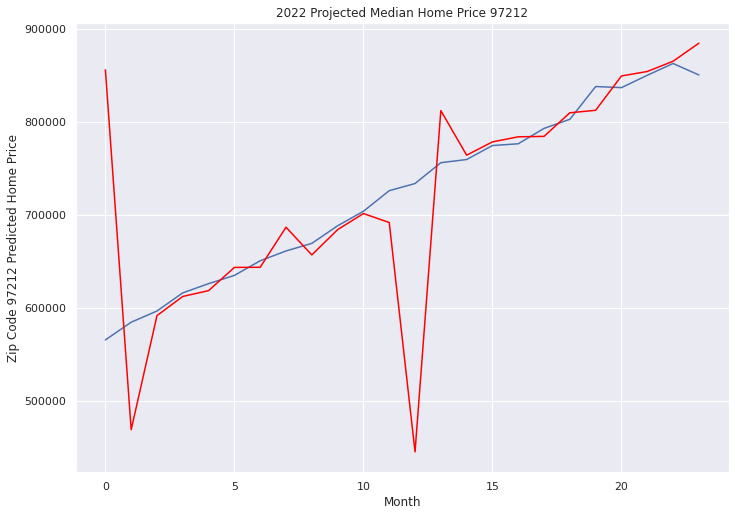

In [ ]:
# MODEL & INTERPRET - 
# CODE FOR MAKING PREDICTION USING SAVED MODEL - LOOKING MANY STEPS AHEAD
# NEED VALIDATION FILE FROM ABOVE


def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load and prepare datasets
dataset = W['Price']
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
#validation = Series.from_csv('validation.csv', header=0)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,1,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
fig, ax = plt.subplots(figsize = dims)
plt.plot(y)
plt.plot(predictions, color='red')
plt.xlabel("Month")
plt.ylabel("Zip Code 97212 Predicted Home Price")
plt.title("2022 Projected Median Home Price 97212")
plt.show()

In [ ]:
# timeseries data
ts_start = Zip98340.columns.get_loc('1996-01-31') + 1
ts_end = Zip98340.columns.get_loc('2022-06-30')
date_columns = Zip98340.iloc[:, ts_start:ts_end].columns.tolist()

# ensure integer timeseries
Zip98340[date_columns] = Zip98340[date_columns].astype(int)

In [ ]:
# train: collapse column by median
train_start = Zip98340.columns.get_loc('1996-01-31')
train_stop = Zip98340.columns.get_loc('2021-12-31')
test_stop = Zip98340.columns.get_loc('2022-06-30')
train_columns = Zip98340.iloc[:, train_start:train_stop].columns.tolist()
test_columns = Zip98340.iloc[:, (train_stop + 1):test_stop].columns.tolist()

In [ ]:
# remove rows with 0's beginning (1997-01) with trainset
#date_columns = Zip97212.iloc[:, train_start:test_stop].columns.tolist()

Zip98340[date_columns] = Zip98340[date_columns].replace(0, np.nan)
Zip98340[date_columns] = Zip98340[date_columns].dropna()

In [ ]:
# Creating training and testing datasets
df_train = Zip98340[train_columns].median().T
df_test = Zip98340[test_columns].median().T

In [ ]:
history = [x for x in df_train]
predictions = list()
iterations = (12-len(df_test)) + 10

for t in range(iterations):
    model = ARIMA(history, order=(0,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)

    if t > 12:
        year = 2022
        month = (t+ 2) % 12
        if month == 0:
            month = 12
    else:
        year = 2022
        month = t+ 2
        if month == 0:
            month = 12

    print('\n===============================================')
    print('date: {}-{:01d}'.format(year, month))
    print('-----------------------------------------------')

    #
    # observation: if current value doesn't exist from test, append current
    #     predition, to ensure successive rolling prediction computed.
    #
    try:
        obs = df_test[t]
        print('predicted={:03f}, expected={:03f}'.format(float(yhat), obs))
        print('prediction difference: {:03f}'.format(abs(1-float(yhat)/obs)))
        print('\n===============================================')
        error = mean_squared_error(df_test, predictions)
        print('Test MSE: {:03f}\n\n'.format(error))
    except:
        obs = yhat
        print('predicted={:03f}'.format(float(yhat)))

    history.append(obs)


date: 2022-2
-----------------------------------------------
predicted=777295.268184, expected=802746.000000
prediction difference: 0.031705

predicted=777295.268184

date: 2022-3
-----------------------------------------------
predicted=779181.094483, expected=838026.000000
prediction difference: 0.070218

predicted=779181.094483

date: 2022-4
-----------------------------------------------
predicted=781066.252570, expected=836825.000000
prediction difference: 0.066631

predicted=781066.252570

date: 2022-5
-----------------------------------------------
predicted=782951.412240, expected=850128.000000
prediction difference: 0.079019

predicted=782951.412240

date: 2022-6
-----------------------------------------------
predicted=784836.571566, expected=862817.000000
prediction difference: 0.090379

Test MSE: 3562628346.399607




/usr/local/lib/python3.7/dist-packages/statsmodels/base/data.py:629: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  endog = np.asarray(endog)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:424: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _endog = endog if hasattr(endog, 'ndim') else np.asarray(endog)



date: 2022-7
-----------------------------------------------
predicted=885498.358320

date: 2022-8
-----------------------------------------------
predicted=887695.563020

date: 2022-9
-----------------------------------------------
predicted=889893.316185

date: 2022-10
-----------------------------------------------
predicted=892091.055185

date: 2022-11
-----------------------------------------------
predicted=894288.797893

date: 2022-12
-----------------------------------------------
predicted=896486.539674

date: 2022-13
-----------------------------------------------
predicted=898684.281705

date: 2022-14
-----------------------------------------------
predicted=900882.023674

date: 2022-3
-----------------------------------------------
predicted=903079.765659

date: 2022-4
-----------------------------------------------
predicted=905277.507640

date: 2022-5
-----------------------------------------------
predicted=907475.249623

date: 2022-6
-----------------------------------

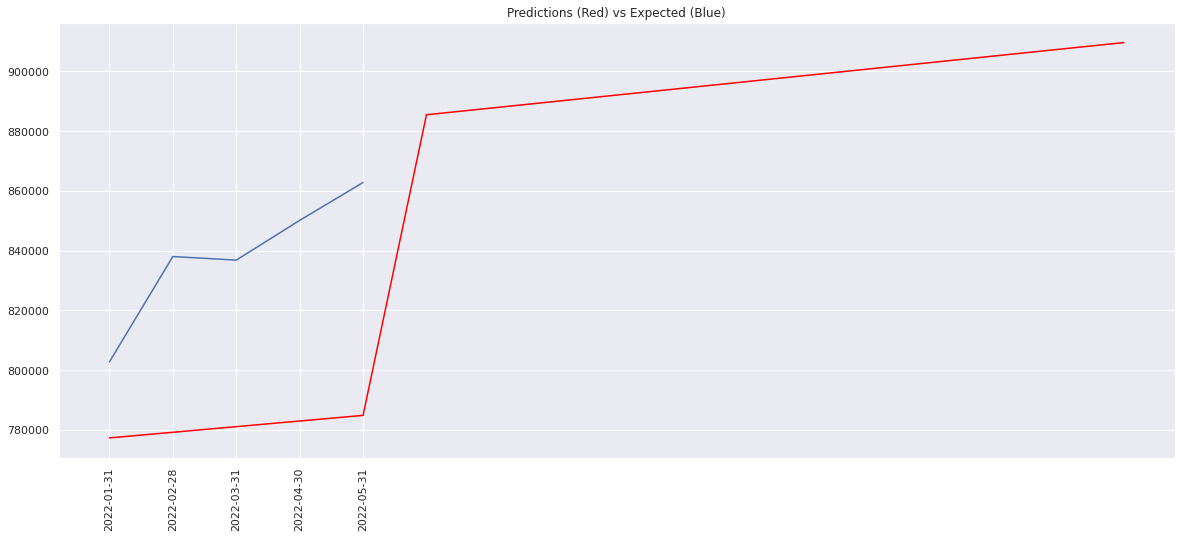

In [ ]:
# plot rolling prediction
def rolling_plot(data, predictions):
    plt.plot(predictions, color='red')
    plt.plot(df_test)
    plt.xticks(rotation=90)
    plt.title('Predictions (Red) vs Expected (Blue)')
    plt.show()
rolling_plot(y, predictions)